**Устанавливаем библиотеки**

In [1]:
!pip install matplotlib
!pip install sklearn
!pip install tensorflow

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


**Импортируем это всё**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
from typing import List
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

**Устанавливаем набор данных**

In [3]:
%%bash

rm -Rf train-images-idx3-ubyte.gz
rm -Rf train-labels-idx1-ubyte.gz
wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

In [4]:
with gzip.open('train-labels-idx1-ubyte.gz') as train_labels:
    data_from_train_file = train_labels.read()

# Пропускаем первые 8 байт
label_data = data_from_train_file[8:]
assert len(label_data) == 60000

# Конвертируем каждый байт в целое число.
# Это будет число от 0 до 9
labels = [int(label_byte) for label_byte in label_data]
assert min(labels) == 0 and max(labels) == 9
assert len(labels) == 60000

In [5]:
SIZE_OF_ONE_IMAGE = 28 ** 2
images = []

# Перебор тренировочного файла и читение одного изображения за раз
with gzip.open('train-images-idx3-ubyte.gz') as train_images:
    train_images.read(4 * 4)
    ctr = 0
    for _ in range(60000):
        image = train_images.read(size=SIZE_OF_ONE_IMAGE)
        assert len(image) == SIZE_OF_ONE_IMAGE

        # Конвертировать в NumPy
        image_np = np.frombuffer(image, dtype='uint8') / 255
        images.append(image_np)

images = np.array(images)
images.shape

(60000, 784)

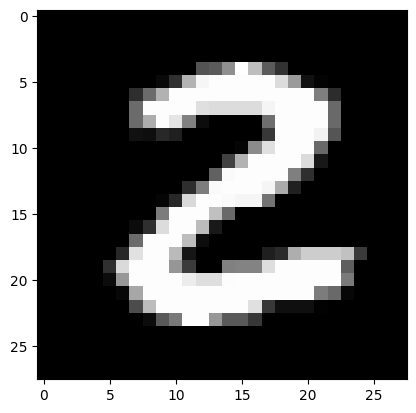

In [9]:
def plot_image(pixels: np.array):
    plt.imshow(pixels.reshape((28, 28)), cmap='gray')
    plt.show()

plot_image(images[25])

**Кодирование меток изображения с помощью One-hot encoding**

In [10]:
labels_np = np.array(labels).reshape((-1, 1))

encoder = OneHotEncoder(categories='auto')
labels_np_onehot = encoder.fit_transform(labels_np).toarray()

labels_np_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [11]:
labels_np_onehot[999]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

**Разделение датасета на тренировочный и тестовый**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_np_onehot)
print(y_train.shape)
print(y_test.shape)

(45000, 10)
(15000, 10)


**Тренировка нейронной сети с помощью Keras**

In [13]:
model = keras.Sequential()
model.add(keras.layers.Dense(input_shape=(SIZE_OF_ONE_IMAGE,), units=128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Обучение нейронной сети**

In [14]:
model.fit(X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
352/352 [==============================] - 3s 7ms/step - loss: 1.3753 - accuracy: 0.6588
Epoch 2/20
352/352 [==============================] - 2s 5ms/step - loss: 0.6585 - accuracy: 0.8453
Epoch 3/20
352/352 [==============================] - 1s 4ms/step - loss: 0.5029 - accuracy: 0.8704
Epoch 4/20
352/352 [==============================] - 1s 4ms/step - loss: 0.4374 - accuracy: 0.8836
Epoch 5/20
352/352 [==============================] - 1s 4ms/step - loss: 0.4002 - accuracy: 0.8903
Epoch 6/20
352/352 [==============================] - 2s 7ms/step - loss: 0.3754 - accuracy: 0.8958
Epoch 7/20
352/352 [==============================] - 2s 5ms/step - loss: 0.3570 - accuracy: 0.9003
Epoch 8/20
352/352 [==============================] - 2s 5ms/step - loss: 0.3425 - accuracy: 0.9038
Epoch 9/20
352/352 [==============================] - 1s 4ms/step - loss: 0.3306 - accuracy: 0.9070
Epoch 10/20
352/352 [==============================] - 1s 4ms/step - loss: 0.3206 - accuracy: 0.9097

In [15]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 1s 2ms/step - loss: 0.2598 - accuracy: 0.9278


[0.25981926918029785, 0.9277999997138977]

**Посмотрим результаты**

In [16]:
y_test[1010]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

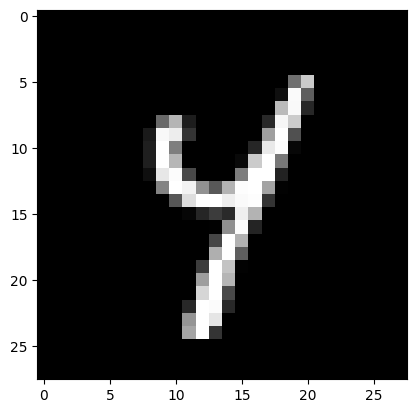

In [17]:
plot_image(X_test[1010])

In [18]:
predicted_results = model.predict(X_test[1010].reshape((1, -1)))

1/1 [==============================] - 0s 189ms/step


In [19]:
predicted_results.sum()

1.0000001

**Чтение вывода слоя softmax для конкретной цифры**

In [20]:
predicted_results

array([[4.8213544e-05, 5.1497770e-03, 8.1728934e-04, 2.7710248e-03,
        8.7488991e-01, 1.7284725e-02, 3.6862490e-03, 1.1289958e-02,
        4.1336954e-02, 4.2725999e-02]], dtype=float32)

**Просмотр матрицы ошибок**

In [21]:
predicted_outputs = np.argmax(model.predict(X_test), axis=1)
expected_outputs = np.argmax(y_test, axis=1)

predicted_confusion_matrix = confusion_matrix(expected_outputs, predicted_outputs)
predicted_confusion_matrix

469/469 [==============================] - 2s 4ms/step


array([[1425,    0,    2,    2,    3,    8,    4,    3,   10,    1],
       [   0, 1621,   10,    5,    2,    4,    3,    7,   16,    1],
       [  14,   17, 1398,   14,   27,    6,   17,   19,   29,    6],
       [   6,    7,   33, 1375,    2,   55,    5,   16,   20,   11],
       [   1,    1,   13,    2, 1302,    1,   10,    2,    9,   57],
       [  14,   12,    8,   32,   14, 1184,   26,    7,   22,   17],
       [  10,    1,    8,    1,   17,   25, 1404,    0,    5,    0],
       [   4,   11,   16,    3,   16,    2,    0, 1483,    1,   38],
       [  13,   23,   15,   42,    7,   37,   12,    2, 1361,   15],
       [   7,    5,    6,   18,   42,    5,    0,   35,    8, 1364]])

**Визуализируем данные**

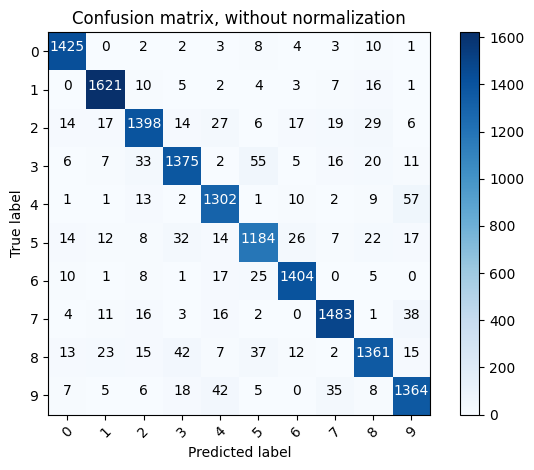

In [22]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
class_names = [str(idx) for idx in range(10)]
cnf_matrix = confusion_matrix(expected_outputs, predicted_outputs)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()